In [1]:
import numpy as np
import pandas as pd
from data.dataloaders import define_data_loaders
from data.data_reader import DataReaderZarr, get_data_readers, get_zarr_readers
from data.partition import DataZarr
from batch.data_transforms.db_with_limits import db_with_limits
import matplotlib.pyplot as plt
from tqdm import tqdm
plt.rcParams["axes.grid"] = False

/home/a39083/.virtualenvs/dino_plain/lib/python3.10/site-packages/xarray/backends/cfgrib_.py:27: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(


# Reading Survey Data

In [2]:
years = [2007,2008,2009,2010,2011,2013,2014,2015,2016,2017,2018]
year_codes = [2007205,2008205,2009107,2010205,2011206,2013842,2014807,2015837,2016837,2017843,2018823]
y = 9

survey_path = f'/scratch/disk5/ahmet/data/{years[y]}' #'/Users/apa055/Desktop/data'

surveys = [f'/{year_codes[y]}/ACOUSTIC/GRIDDED/{year_codes[y]}_sv.zarr']
readers = [DataReaderZarr(survey_path + zarr_file) for zarr_file in surveys]

survey = readers[0]
survey.year

2017

# Reading Feaures and Undersampling

In [3]:
def process_data(features):
    features[1].replace({'other_seabed': 'other', 'sandeel_seabed': 'sandeel', 'seabed': 'background'}, inplace=True)
    features.reset_index(drop=True, inplace=True)

    value = min(features[1].value_counts().get('other', 0), features[1].value_counts().get('sandeel', 0))

    # Undersampling for Class Balance
    np.random.seed(1)
    features = features.groupby(1, group_keys=False).apply(lambda x: x.sample(min(value, len(x)), replace=False))
    filtered_df = features[~features[1].isin(['other_seabed', 'sandeel_seabed', 'sandeel_other', 'sandeel_other_seabed'])]
    features = filtered_df.reset_index(drop=True)
    features.dropna(inplace=True)
    features = features.reset_index(drop=True)
    return features

In [4]:

# 64 DEGIL ORJINAL
features_DINO_64 = pd.read_csv('/scratch/disk5/ahmet/dino_output/extracted_features/Undersampled_Patch_Array_Features/Model25_2017_8w.csv', header=None, sep=r',|\t', engine='python')

features_DINO=process_data(features_DINO_64)
features_DINO.iloc[:, 1].value_counts()

other         13806
background    13806
sandeel       13806
Name: 1, dtype: int64

In [5]:
features_DINO.iloc[:,9].mean()

-65.432655664257

In [6]:

features_pixels = features_DINO.drop(columns=features_DINO.columns[11:])
features_pixels

frequencies = [18, 38, 120, 200]
window_size = [8, 8]
#print(len(filtered_rows))
ping_extend = 0

new_columns = ['pixel' + str(i) for i in range(256)]
features_pixels[new_columns] = np.nan

for i in tqdm(range(len(features_pixels)), desc="Processing rows"):
    row = features_pixels.iloc[i]
    ping_start = row[4] - window_size[0] // 2 - ping_extend
    ping_end = row[4] + window_size[0] // 2 + ping_extend
    range_start = max(row[3] - window_size[0] // 2 - ping_extend, 0)
    range_end = row[3] + window_size[0] // 2 + ping_extend
    ping_slice, range_slice = slice(ping_start, ping_end), slice(range_start, range_end)

    dat1 = survey.ds.sv.isel(ping_time=ping_slice, range=range_slice).sel(frequency=frequencies)
    dat1_values = db_with_limits(dat1.values, 1, 2, frequencies)[0].flatten()

    features_pixels.loc[i, new_columns] = dat1_values

features_pixels.to_csv('features_pixels.csv', index=False)

Processing rows:   0%|          | 6/41418 [00:04<8:20:43,  1.38it/s]


KeyboardInterrupt: 

In [7]:
# Reading the Data
features_pixels = pd.read_csv('features_pixels.csv')
features_pixels

,0,1,2,3,4,5,6,7,8,9,...,pixel246,pixel247,pixel248,pixel249,pixel250,pixel251,pixel252,pixel253,pixel254,pixel255
0,32553,background,2017,108,683660,background,0,0,0,-70.413610,...,-71.881742,-70.809070,-75.000000,-75.000000,-75.000000,-75.000000,-75.000000,-75.000000,-75.000000,-75.000000
1,110637,background,2017,244,755476,seabed,0,0,37,-44.470948,...,-24.697020,-24.502302,-71.992066,-75.000000,-75.000000,-46.800984,-8.436180,-8.441066,-9.139887,-9.274416
2,107170,background,2017,252,531860,seabed,0,0,2,-74.653352,...,-75.000000,-64.963141,-75.000000,-75.000000,-75.000000,-75.000000,-75.000000,-75.000000,-75.000000,-75.000000
3,97162,background,2017,308,55588,seabed,0,0,12,-67.204659,...,-75.000000,-23.951137,-75.000000,-75.000000,-75.000000,-75.000000,-75.000000,-75.000000,-75.000000,-53.313227
4,121513,background,2017,492,1431444,seabed,0,0,2,-71.070074,...,-75.000000,-75.000000,-75.000000,-75.000000,-75.000000,-75.000000,-75.000000,-75.000000,-75.000000,-75.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41413,74484,sandeel,2017,180,1286588,sandeel,0,64,0,-66.796544,...,-67.745839,-72.530891,-66.761792,-67.434398,-73.779255,-68.639281,-67.585189,-64.250779,-65.841804,-70.440773
41414,55825,sandeel,2017,108,627308,sandeel,0,64,0,-72.084950,...,-67.382375,-65.826834,-75.000000,-74.530161,-72.821194,-74.257150,-72.303009,-68.656354,-67.276605,-65.579993
41415,61901,sandeel,2017,76,77900,sandeel,0,64,0,-62.776441,...,-51.178282,-52.528260,-69.905855,-65.498757,-60.492024,-59.460548,-60.911595,-65.855660,-67.485612,-64.850428
41416,80479,sandeel,2017,68,677164,sandeel,0,54,0,-71.615718,...,-75.000000,-75.000000,-68.342598,-61.520540,-62.588431,-61.695001,-67.116469,-71.972487,-65.810308,-65.395106


# AUC for Original Values

Macro Average AUC: 0.7978703887978496


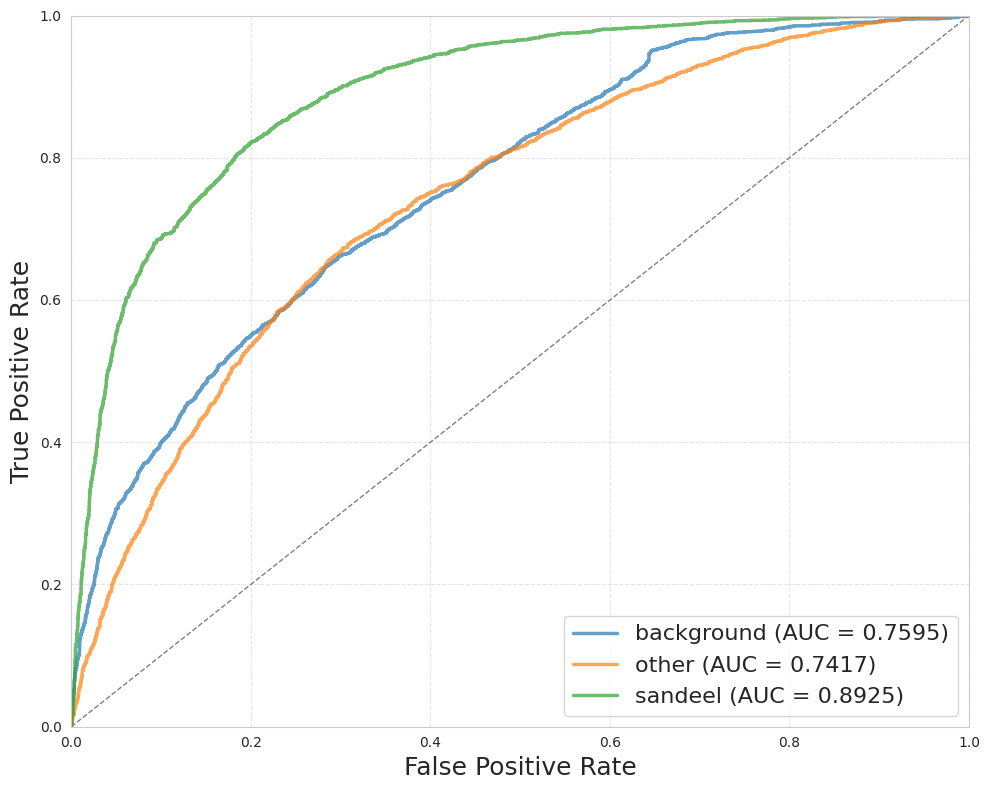

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, accuracy_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

X = features_pixels.iloc[:, 11:].values
y = features_pixels.iloc[:, 1]

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.20, stratify=y_encoded, random_state=42)

logreg = LogisticRegression(solver='saga', multi_class='multinomial', C=100, max_iter=500)
logreg.fit(X_train, y_train)

y_pred_prob = logreg.predict_proba(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(label_encoder.classes_)):
    fpr[i], tpr[i], _ = roc_curve((y_test == i).astype(int), y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

macro_auc = np.mean(list(roc_auc.values()))

print("Macro Average AUC:", macro_auc)

plt.figure(figsize=(10, 8))
for i in range(len(label_encoder.classes_)):
    plt.plot(fpr[i], tpr[i], label=f'{label_encoder.classes_[i]} (AUC = {roc_auc[i]:.4f})', 
             linewidth=2.5, alpha=0.7)

plt.plot([0, 1], [0, 1], color='gray', linestyle='--', linewidth=1) 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.legend(loc="lower right", fontsize=16)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig('ROC_original_Sv', dpi=600)
plt.show()


In [6]:
roc_auc

{0: 0.7594488636404623, 1: 0.7416751770591166, 2: 0.8924824040025796}

# kNN On the Original Pixels

Accuracy: 71.3544%
Confusion Matrix:
[[2567  109   85]
 [ 992 1258  511]
 [ 601   75 2086]]


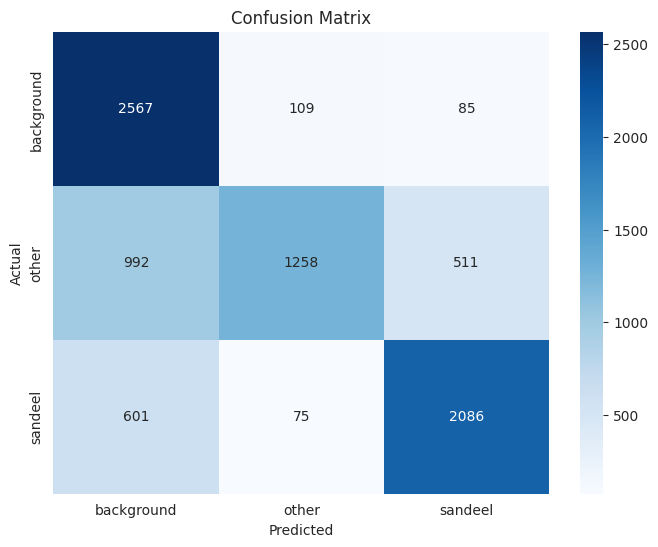

In [14]:
# kNN on Pixels
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import plotly.graph_objects as go
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D


X = features_pixels.iloc[:, 11:]
y = features_pixels.iloc[:, 1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)

knn = KNeighborsClassifier(n_neighbors=25, metric='euclidean')
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)


y_pred = knn.predict(X_test)

misclassified_samples = X_test[y_test != y_pred]
misclassified_real_classes = y_test[y_test != y_pred]
misclassified_predicted_classes = y_pred[y_test != y_pred]

misclassified_indices = X_test.index[y_test != y_pred]

original_rows = features_pixels.iloc[misclassified_indices, :].copy()
original_rows.insert(0, 'Predicted Class', misclassified_predicted_classes)


correctly_classified_indices = X_test.index[y_test == y_pred]
correctly_classified_original_rows = features_pixels.iloc[correctly_classified_indices, :].copy()
correctly_classified_original_rows.insert(0, 'Predicted Class', y_pred[y_test == y_pred])


accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.4f}%')

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=features_pixels.iloc[:,1].unique(), yticklabels=features_pixels.iloc[:,1].unique())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)

X_test_pca = pca.transform(X_test)

fig = go.Figure()
for label in features_pixels.iloc[:, 1].unique():
    indices = (y_test == label)
    fig.add_trace(go.Scatter3d(
        x=X_test_pca[indices, 0],
        y=X_test_pca[indices, 1],
        z=X_test_pca[indices, 2],
        mode='markers',
        name=label,
        marker=dict(size=2, symbol='circle')
    ))

fig.update_layout(
    scene=dict(
        xaxis_title='Principal Component 1',
        yaxis_title='Principal Component 2',
        zaxis_title='Principal Component 3'
    ),
    title='Interactive 3D Scatter Plot of Test Set Predictions',
    legend=dict(x=0, y=1.0),
    width=800,  
    height=600, 
)
fig.show()

# Linear Regression on Number of Sandeel Pixels

Root Mean Squared Error (RMSE) on the test set: 13.5454
R-squared on the test set: 0.4454
Mean Absolute Error (MAE) on the test set: 10.2339


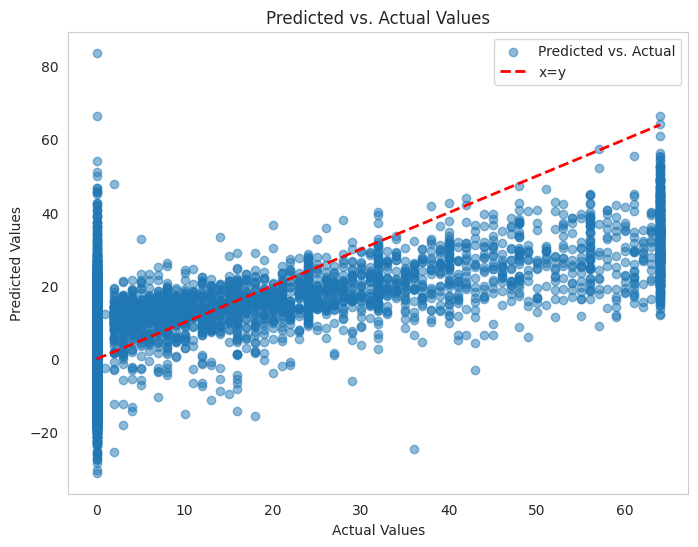

In [4]:
# Linear Classifier on DINO features (512)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt


X = features_pixels.iloc[:, 11:]
y = features_pixels.iloc[:, 7] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

model = LinearRegression()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

#y_pred = np.maximum(y_pred, 0)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Root Mean Squared Error (RMSE) on the test set: {rmse:.4f}')

r2 = r2_score(y_test, y_pred)
print(f'R-squared on the test set: {r2:.4f}')

mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error (MAE) on the test set: {mae:.4f}')

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5, label='Predicted vs. Actual')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', linewidth=2, label='x=y')
plt.title('Predicted vs. Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()


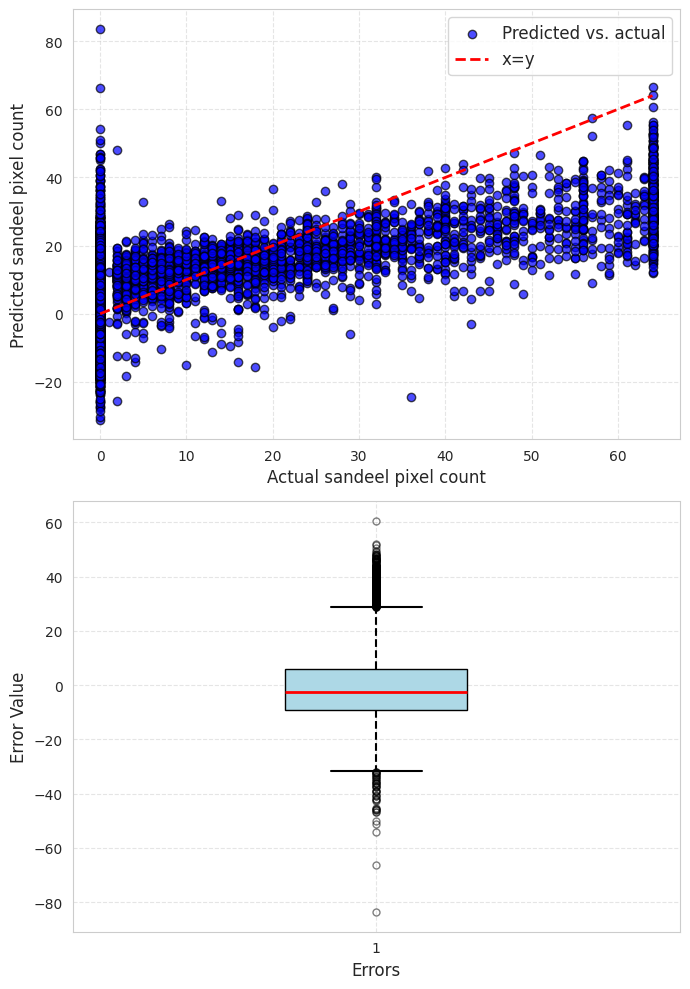

In [5]:
# Plotting both predicted versus actual values and error distribution

errors = y_test - y_pred


plt.figure(figsize=(7, 10))

# Scatter plot (First Row)
plt.subplot(2, 1, 1)
plt.scatter(y_test, y_pred, alpha=0.7, label='Predicted vs. actual', color='blue', marker='o', edgecolors='black')  
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', linewidth=2, label='x=y')  
plt.xlabel('Actual sandeel pixel count', fontsize=12)  
plt.ylabel('Predicted sandeel pixel count', fontsize=12)  
plt.legend(fontsize=12)  
plt.grid(True, linestyle='--', alpha=0.5)  

plt.subplots_adjust(hspace=2)

plt.subplot(2, 1, 2)
box = plt.boxplot(errors, vert=True, widths=0.3, patch_artist=True, boxprops=dict(facecolor='lightblue', color='black'), whiskerprops=dict(color='black'), medianprops=dict(color='red'))

for whisker in box['whiskers']:
    whisker.set_linestyle('--')
    whisker.set_linewidth(1.5)
for cap in box['caps']:
    cap.set_color('black')
    cap.set_linewidth(1.5)
for median in box['medians']:
    median.set_linewidth(2)
for flier in box['fliers']:
    flier.set(marker='o', color='blue', alpha=0.5, markersize=5)  

plt.xlabel('Errors', fontsize=12)  
plt.ylabel('Error Value', fontsize=12)  
plt.grid(True, linestyle='--', alpha=0.5)  

plt.subplots_adjust(hspace=2)

plt.tight_layout()  
plt.savefig('Combined_Predicted_vs_Actual_sandeel_and_Error_original_pixel',dpi=600)
plt.show()


In [25]:
len(y_test)

2902

Root Mean Squared Error (RMSE) on the test set: 14.44
R-squared on the test set: 0.55
Mean Absolute Error (MAE) on the test set: 11.40


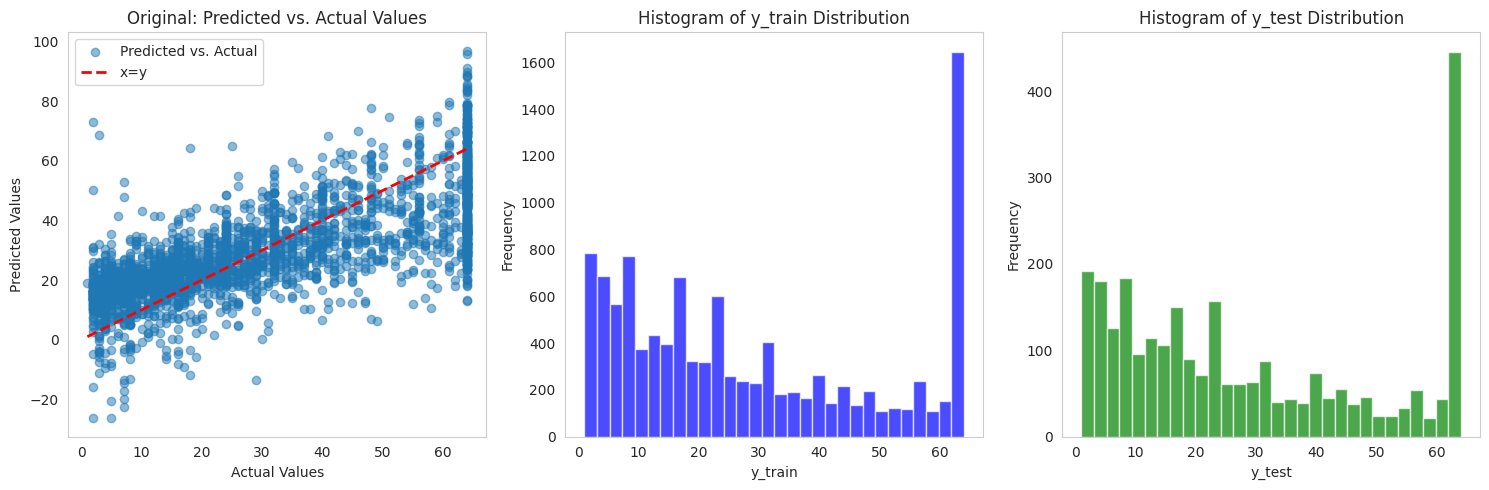

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)
X = features_pixels.iloc[:, 11:]
y = features_pixels.iloc[:, 7] 

zero_indices = y[y == 0].index
random_indices = np.random.choice(zero_indices, size=0, replace=False)

non_zero_indices = y[y != 0].index

selected_indices = np.concatenate([random_indices, non_zero_indices])

X_selected = X.loc[selected_indices]
y_selected = y.loc[selected_indices]

X_train, X_test, y_train, y_test = train_test_split(X_selected, y_selected, test_size=0.20, random_state=42)

model = LinearRegression()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

#y_pred = np.maximum(y_pred, 0)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Root Mean Squared Error (RMSE) on the test set: {rmse:.2f}')

r2 = r2_score(y_test, y_pred)
print(f'R-squared on the test set: {r2:.2f}')

mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error (MAE) on the test set: {mae:.2f}')

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(y_test, y_pred, alpha=0.5, label='Predicted vs. Actual')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', linewidth=2, label='x=y')
plt.title('Original: Predicted vs. Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()

plt.subplot(1, 3, 2)
plt.hist(y_train, bins=30, color='blue', alpha=0.7)
plt.title('Histogram of y_train Distribution')
plt.xlabel('y_train')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
plt.hist(y_test, bins=30, color='green', alpha=0.7)
plt.title('Histogram of y_test Distribution')
plt.xlabel('y_test')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()
